In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [2]:
np.random.seed(42)
torch.random.manual_seed(42)

In [3]:
# 计算图像数据中的最大像素值
max_pixel_value = 107.49169921875

In [4]:
class NO2Dataset(Dataset):
    
    def __init__(self, image_dir, mask_dir):
        
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.npy')]  # 仅加载 .npy 文件
        self.mask_filenames = [f for f in os.listdir(mask_dir) if f.endswith('.jpg')]  # 仅加载 .jpg 文件
        
    def __len__(self):
        
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_idx = np.random.choice(self.mask_filenames)
        mask_path = os.path.join(self.mask_dir, mask_idx)

        # 加载图像数据 (.npy 文件)
        image = np.load(image_path).astype(np.float32)[:,:,:1] / max_pixel_value  # 形状为 (96, 96, 1)

        # 加载掩码数据 (.jpg 文件)
        mask = np.array(Image.open(mask_path).convert('L')).astype(np.float32)

        # 将掩码数据中非0值设为1，0值保持不变
        mask = np.where(mask != 0, 1.0, 0.0)

        # 保持掩码数据形状为 (96, 96, 1)
        mask = mask[:, :, np.newaxis]  # 将形状调整为 (96, 96, 1)

        # 应用掩码
        masked_image = image.copy()
        masked_image[:, :, 0] = image[:, :, 0] * mask.squeeze()  # 遮盖NO2数据

        # cGAN的输入和目标
        X = masked_image[:, :, :1]  # 形状为 (96, 96, 8)
        y = image[:, :, 0:1]  # 目标输出为NO2数据，形状为 (96, 96, 1)

        # 转换形状为 (channels, height, width)
        X = np.transpose(X, (2, 0, 1))  # 转换为 (1, 96, 96)
        y = np.transpose(y, (2, 0, 1))  # 转换为 (1, 96, 96)
        mask = np.transpose(mask, (2, 0, 1))  # 转换为 (1, 96, 96)

        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

# 实例化数据集和数据加载器
image_dir = './out_mat/96/train/'
mask_dir = './out_mat/96/mask/20/'

print(f"checkpoint before Generator is OK")

checkpoint before Generator is OK


In [5]:
train_set = NO2Dataset(image_dir, mask_dir)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=8)
val_set = NO2Dataset('./out_mat/96/valid/', mask_dir)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=4)
test_set = NO2Dataset('./out_mat/96/test/', mask_dir)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=4)

In [6]:
# 可视化特定特征的函数
def visualize_feature(input_feature,masked_feature, output_feature, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(input_feature[0].cpu().numpy(), cmap='RdYlGn_r')
    plt.title(title + " Input")
    plt.subplot(1, 3, 2)
    plt.imshow(masked_feature[0].cpu().numpy(), cmap='RdYlGn_r')
    plt.title(title + " Masked")
    plt.subplot(1, 3, 3)
    plt.imshow(output_feature[0].detach().cpu().numpy(), cmap='RdYlGn_r')
    plt.title(title + " Recovery")
    plt.show()

In [7]:
class Conv(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1, stride=1, bias=False):
        super(Conv, self).__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, bias=bias,
                      dilation=dilation, stride=stride, padding=((stride - 1) + dilation * (kernel_size - 1)) // 2)
        )

In [8]:
class ConvBNReLU(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1, stride=1, norm_layer=nn.BatchNorm2d,
                 bias=False):
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, bias=bias,
                      dilation=dilation, stride=stride, padding=((stride - 1) + dilation * (kernel_size - 1)) // 2),
            norm_layer(out_channels),
            nn.ReLU()
        )

In [9]:
class SeparableBNReLU(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dilation=1, norm_layer=nn.BatchNorm2d):
        super(SeparableBNReLU, self).__init__(
            nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, dilation=dilation,
                      padding=((stride - 1) + dilation * (kernel_size - 1)) // 2, groups=in_channels, bias=False),
            # 分离卷积，仅调整空间信息
            norm_layer(in_channels),  # 对输入通道进行归一化
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),  # 这里进行升维操作
            nn.ReLU6()
        )

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 如果输入和输出通道不一致，进行降采样操作
        self.downsample = downsample
        if in_channels != out_channels or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)
        return out


In [11]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.ReLU6, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Conv2d(in_features, hidden_features, 1, 1, 0, bias=True)

        self.act = act_layer()
        self.fc2 = nn.Conv2d(hidden_features, out_features, 1, 1, 0, bias=True)
        self.drop = nn.Dropout(drop, inplace=True)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [12]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(MultiHeadAttentionBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # (B, C, H, W) -> (HW, B, C) for MultiheadAttention compatibility
        B, C, H, W = x.shape
        x = x.view(B, C, H * W).permute(2, 0, 1)  # (B, C, H, W) -> (HW, B, C)

        # Apply multihead attention
        attn_output, _ = self.attention(x, x, x)

        # Apply normalization and dropout
        attn_output = self.norm(attn_output)
        attn_output = self.dropout(attn_output)

        # Reshape back to (B, C, H, W)
        attn_output = attn_output.permute(1, 2, 0).view(B, C, H, W)

        return attn_output

In [13]:
class SpatialAttentionBlock(nn.Module):
    def __init__(self):
        super(SpatialAttentionBlock, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)

    def forward(self, x): #(B, 64, H, W)
        avg_out = torch.mean(x, dim=1, keepdim=True) #(B, 1, H, W)
        max_out, _ = torch.max(x, dim=1, keepdim=True)#(B, 1, H, W)
        out = torch.cat([avg_out, max_out], dim=1)#(B, 2, H, W)
        out = torch.sigmoid(self.conv(out))#(B, 1, H, W)
        return x * out #(B, C, H, W)

In [14]:
class DecoderAttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(DecoderAttentionBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 2, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels // 2, in_channels, kernel_size=1)
        self.spatial_attention = SpatialAttentionBlock()

    def forward(self, x):
        # 通道注意力
        b, c, h, w = x.size()
        avg_pool = F.adaptive_avg_pool2d(x, 1)
        max_pool = F.adaptive_max_pool2d(x, 1)

        avg_out = self.conv1(avg_pool)
        max_out = self.conv1(max_pool)

        out = avg_out + max_out
        out = torch.sigmoid(self.conv2(out))

        # 添加空间注意力
        out = x * out
        out = self.spatial_attention(out)
        return out

In [15]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SEBlock, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # 全局平均池化
            nn.Conv2d(in_channels, reduced_dim, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(reduced_dim, in_channels, kernel_size=1),
            nn.Sigmoid()  # 使用Sigmoid是因为我们要对通道进行权重归一化
        )

    def forward(self, x):
        return x * self.se(x)

In [16]:
def masked_mse_loss(preds, target, mask):
    loss = (preds - target) ** 2
    loss = loss.mean(dim=-1)  # 对每个像素点求平均
    loss = (loss * (1-mask)).sum() / (1-mask).sum()  # 只计算被mask的像素点的损失
    return loss

In [17]:
# 定义Masked Autoencoder模型
class MaskedAutoencoder(nn.Module):
    def __init__(self):
        super(MaskedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            Conv(1, 32, kernel_size=3, stride=2),
            
            nn.ReLU(),
            
            SEBlock(32,32),
            
            ConvBNReLU(32, 64, kernel_size=3, stride=2),
            
            ResidualBlock(64,64),
            
            SeparableBNReLU(64, 128, kernel_size=3, stride=2),
            
            MultiHeadAttentionBlock(embed_dim=128, num_heads=4),
            
            SEBlock(128, 128)
            
        )
        # self.mlp = Mlp(in_features=128, hidden_features=256, out_features=128, act_layer=nn.ReLU6, drop=0.1)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            
            DecoderAttentionBlock(32),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            
            DecoderAttentionBlock(16),
            nn.ReLU(),
            
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 修改为 output_padding=1
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 实例化模型、损失函数和优化器
model = MaskedAutoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [18]:
# 训练函数
def train_epoch(model, device, data_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, mask) in enumerate(data_loader):
        X, y, mask = X.to(device), y.to(device), mask.to(device)
        optimizer.zero_grad()
        reconstructed = model(X)
        loss = masked_mse_loss(reconstructed, y, mask)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / (batch_idx + 1)

In [19]:
# 评估函数
def evaluate(model, device, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_idx, (X, y, mask) in enumerate(data_loader):
            X, y, mask = X.to(device), y.to(device), mask.to(device)
            reconstructed = model(X)
            if batch_idx == 8:
                rand_ind = np.random.randint(0, len(y))
                # visualize_feature(y[rand_ind], X[rand_ind], reconstructed[rand_ind], title='NO_2')
            loss = masked_mse_loss(reconstructed, y, mask)
            running_loss += loss.item()
    return running_loss / (batch_idx + 1)

In [20]:
# 数据准备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [21]:
model = model.to(device)

num_epochs = 160
train_losses = list()
val_losses = list()
for epoch in range(num_epochs):
    train_loss = train_epoch(model, device, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    val_loss = evaluate(model, device, val_loader, criterion)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

# 测试模型
test_loss = evaluate(model, device, test_loader, criterion)
print(f'Test Loss: {test_loss}')

/root/miniconda3/envs/python38/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1711403590347/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1, Train Loss: 1.828955806274876, Val Loss: 0.08777590596408986
Epoch 2, Train Loss: 0.06457909727781012, Val Loss: 0.05018303115198861
Epoch 3, Train Loss: 0.04399169035006368, Val Loss: 0.03933813378437242
Epoch 4, Train Loss: 0.03737294341049839, Val Loss: 0.04090026577017201
Epoch 5, Train Loss: 0.03340746862947513, Val Loss: 0.029788545930563515
Epoch 6, Train Loss: 0.03127880183240158, Val Loss: 0.02878953230136366
Epoch 7, Train Loss: 0.030086695853816837, Val Loss: 0.027378849156979305
Epoch 8, Train Loss: 0.02827827861470184, Val Loss: 0.026564865748384105
Epoch 9, Train Loss: 0.026973650764014447, Val Loss: 0.026876062349374615
Epoch 10, Train Loss: 0.026198443756149145, Val Loss: 0.025235873994542593
Epoch 11, Train Loss: 0.025248640154501754, Val Loss: 0.025164278752323407
Epoch 12, Train Loss: 0.0246738152373493, Val Loss: 0.02402887423870279
Epoch 13, Train Loss: 0.02429686849446673, Val Loss: 0.02467221769490349
Epoch 14, Train Loss: 0.023617587716242915, Val Loss:

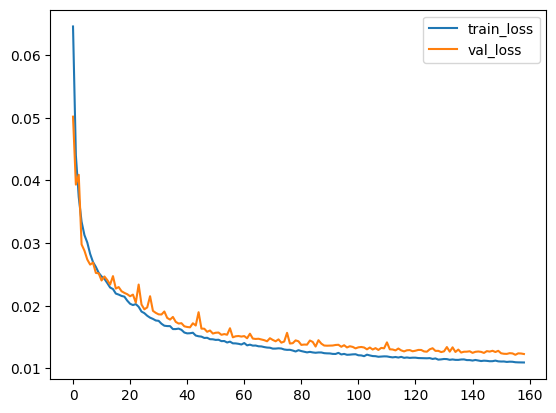

In [23]:
tr_ind = list(range(len(train_losses)))
val_ind = list(range(len(val_losses)))
plt.plot(train_losses[1:], label='train_loss')
plt.plot(val_losses[1:], label='val_loss')
plt.legend(loc='best')

In [24]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error

In [25]:
def cal_ioa(y_true, y_pred):
    # 计算平均值
    mean_observed = np.mean(y_true)
    mean_predicted = np.mean(y_pred)

    # 计算IoA
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((np.abs(y_true - mean_observed) + np.abs(y_pred - mean_predicted)) ** 2)
    IoA = 1 - (numerator / denominator)

    return IoA

In [26]:
eva_list = list()
device = 'cpu'
model = model.to(device)
with torch.no_grad():
    for batch_idx, (X, y, mask) in enumerate(test_loader):
        X, y, mask = X.to(device), y.to(device), mask.to(device)
        mask_rev = (torch.squeeze(mask, dim=1)==0) * 1 # mask取反获得修复区域
        reconstructed = model(X)
        rev_data = y * max_pixel_value
        rev_recon = reconstructed * max_pixel_value
        # todo: 这里需要只评估修补出来的模块
        data_label = torch.squeeze(rev_data, dim=1) * mask_rev
        data_label = data_label[mask_rev==1]
        recon_no2 = torch.squeeze(rev_recon, dim=1) * mask_rev
        recon_no2 = recon_no2[mask_rev==1]
        mae = mean_absolute_error(data_label, recon_no2)
        rmse = np.sqrt(mean_squared_error(data_label, recon_no2))
        mape = mean_absolute_percentage_error(data_label, recon_no2)
        r2 = r2_score(data_label, recon_no2)
        ioa = cal_ioa(data_label.detach().numpy(), recon_no2.detach().numpy())
        r = np.corrcoef(data_label, recon_no2)[0, 1]
        eva_list.append([mae, rmse, mape, r2, ioa, r])

In [ ]:
pd.DataFrame(eva_list, columns=['mae', 'rmse', 'mape', 'r2', 'ioa', 'r']).describe().to_csv('./eva.csv')

In [32]:
model_20 = torch.load('./models/MAE/final_20.pt')

In [38]:
# 可视化特定特征的函数
def visualize_rst(input_feature,masked_feature, recov_region, output_feature, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(input_feature, cmap='RdYlGn_r')
    plt.gca().axis('off')  # 获取当前坐标轴并关闭
    
    plt.subplot(1, 4, 2)
    plt.imshow(masked_feature, cmap='gray')
    plt.gca().axis('off')  # 获取当前坐标轴并关闭
    plt.subplot(1, 4, 3)
    plt.imshow(recov_region, cmap='RdYlGn_r')
    plt.gca().axis('off')  # 获取当前坐标轴并关闭
    plt.subplot(1, 4, 4)
    plt.imshow(output_feature, cmap='RdYlGn_r')
    plt.gca().axis('off')  # 获取当前坐标轴并关闭
    plt.savefig('./figures/result/20_samples.png', bbox_inches='tight')